In [1]:
# импортнул либы с запасом)
import pandas as pd
import numpy as np
import pandahouse as ph
from datetime import date
import holidays
from fbprophet import Prophet

In [2]:
#  вхожу в кликауз.
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
        * 
    FROM 
        {db}.ldn_listings 
    LIMIT 10
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_default = ph.read_clickhouse(query=q, connection=connection_default)
q_default

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20200510041510,2020-05-13,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,3,1,2,0,0.18
1,15400,https://www.airbnb.com/rooms/15400,20200510041510,2020-05-13,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,t,f,strict_14_with_grace_period,t,t,1,1,0,0,0.70
2,17402,https://www.airbnb.com/rooms/17402,20200510041510,2020-05-12,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"This is a wonderful very popular beautiful, sp...",You'll have a wonderful stay in this superb mo...,none,"Location, location, location! You won't find b...",...,t,f,strict_14_with_grace_period,f,f,15,15,0,0,0.38
3,17506,https://www.airbnb.com/rooms/17506,20200510041510,2020-05-12,Boutique Chelsea/Fulham Double bed 5-star ensuite,Enjoy a chic stay in this elegant but fully mo...,Enjoy a boutique London townhouse bed and brea...,Enjoy a chic stay in this elegant but fully mo...,business,Fulham is 'villagey' and residential – a real ...,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,0.00
4,25023,https://www.airbnb.com/rooms/25023,20200510041510,2020-05-14,All-comforts 2-bed flat near Wimbledon tennis,"Large, all comforts, 2-bed flat; first floor; ...",10 mins walk to Southfields tube and Wimbledon...,"Large, all comforts, 2-bed flat; first floor; ...",none,This is a leafy residential area with excellen...,...,f,f,moderate,f,f,1,1,0,0,0.69
5,25123,https://www.airbnb.com/rooms/25123,20200510041510,2020-05-14,Clean big Room in London (Room 1),Big room with double bed/ clean sheets/ clean ...,Big double Room to let up to 6 months or more....,Big room with double bed/ clean sheets/ clean ...,none,Barnet is one of the largest boroughs in Londo...,...,t,f,strict_14_with_grace_period,f,f,3,0,3,0,1.05
6,33332,https://www.airbnb.com/rooms/33332,20200510041510,2020-05-14,Beautiful Ensuite Richmond-upon-Thames borough,"Walking distance to Twickenham Stadium, 35 min...",This is a spacious Bedsit + En-Suite at the to...,"Walking distance to Twickenham Stadium, 35 min...",none,Peaceful and friendly.,...,f,f,flexible,f,f,2,1,1,0,0.05
7,36299,https://www.airbnb.com/rooms/36299,20200510041510,2020-05-14,Kew Gardens 3BR house in cul-de-sac,3 Bed House with garden close to Thames river ...,"Residential neighborhood, mix of English and c...",3 Bed House with garden close to Thames river ...,none,"Residential family neighborhood, with both Eng...",...,f,f,moderate,f,f,1,1,0,0,0.66
8,36660,https://www.airbnb.com/rooms/36660,20200510041510,2020-05-14,You are GUARANTEED to love this,,This room is located on the ground floor of th...,This room is located on the ground floor of th...,none,,...,t,f,strict_14_with_grace_period,f,f,4,0,4,0,4.49
9,36986,https://www.airbnb.com/rooms/36986,20200510041510,2020-05-13,Gorgeous Victorian Flat Overlooking London Fields,Situated literally in London Fields park and o...,The flat is situated in the beautiful area of ...,Situated literally in London Fields park and o...,none,London Fields is one of the most vibrant and e...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.44


In [4]:
#  посчитаем количество строк в таблице

q = '''
    SELECT 
        count(id)
    FROM 
        {db}.ldn_listings 
    LIMIT 10
    '''
q_default = ph.read_clickhouse(query=q, connection=connection_default)
q_default

,count(id)
0,85207


In [5]:
# выгружаем таблицу 
q = '''
    SELECT  room_type, 
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' )) AS price
FROM default.ldn_listings
ORDER BY id ASC
LIMIT 1000
    '''
q_default = ph.read_clickhouse(query=q, connection=connection_default)
q_default

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [6]:
# # теперь Далее - что бы посчитать прецентиль, нам необходимо взять наш df, 
# сгруппироваться по roomtype и к price применить .quantile(0.75)

# Выглядит примерно так:
#  датафрейм.группировка([колонка]).колонкаподсчёта.quantile(0.75) 

#  df.groupby(['room_type'])['price'].quantile(0.75)  означает, что вы сначала выполняете группировку по столбцу 'room_type', а затем получаете доступ к столбцу 'price' внутри каждой группы и вычисляете квантиль 0.75 для этого столбца.
#     df.groupby(['room_type']).price.quantile(0.75)   пытается получить доступ к столбцу 'price' сразу после операции группировки и вот такой синтаксис может вызвать ошибку, потому что Pandas не разрешает выполнять агрегирующие операции непосредственно на столбце после группировки.
# Поэтому, для выполнения агрегации на столбце внутри группировки, вам надо использовать квадратные скобки [] после группировки, указывая столбец, на котором вы хотите выполнить операцию - ну в нащем случае это .quantile().

# 3) Почему в quantile мы указываем 0.75? Это для того, что бы найти перцентиль, и это работает именно так)

quantile = q_default.groupby(['room_type'])['price'].quantile(0.75)
quantile

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

In [7]:
# К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). 
# В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

In [8]:
q = '''
   SELECT  room_type, 
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '' )) AS price,
  toFloat32OrNull(review_scores_rating) as review_scores_rating
FROM default.ldn_listings
WHERE review_scores_rating > 0
ORDER BY id ASC
LIMIT 1000
    '''
q_defaults = ph.read_clickhouse(query=q, connection=connection_default)
q_defaults

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [9]:
# 1) сгруппируйте датафрейм по типу жилья и посчитайте 
# среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)


result = q_defaults.groupby('room_type', as_index = False)[['price', 'review_scores_rating']].mean()
result

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


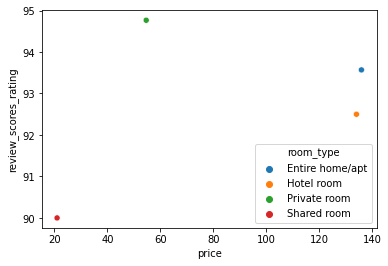

In [10]:
# 2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены 
# (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

# из документации следует что необходимо импортировать сиборн.
import seaborn as sns
sns.scatterplot(data=result, x="price", y="review_scores_rating", hue="room_type")

In [32]:
# Проверим, какие способы верификации аккаунта использовали хозяева, 
# предлагающие различные впечатления (experiences_offered != 'none'). 
# Для каждого уникального пользователя выгрузите только две колонки:

# host_id – идентификатор хозяина (уникальный)
# host_verifications – какими способами хост подтвердил свой профиль

q = '''
SELECT DISTINCT(host_id) AS host_id, id, host_verifications
FROM default.ldn_listings
WHERE experiences_offered != 'none'
ORDER BY id ASC
LIMIT 1000
    '''

# SELECT
#     DISTINCT(host_id) AS host_id,
#     replaceRegexpAll(host_verifications, '[]['' ]', '') AS host_verifications
# FROM ldn_listings
# WHERE experiences_offered != 'none'
# GROUP BY host_id, host_verifications
# """

verifications = ph.read_clickhouse(query=q, connection=connection_default)
verifications.head(5)

,host_id,id,host_verifications
0,54730,13913,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,15400,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,17506,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,38950,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,41311,"['email', 'phone', 'reviews', 'offline_governm..."


In [26]:
# Затем обработайте столбец host_verifications:

# В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). 
# Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 

In [27]:
# NEW_verifications = verifications.apply(lambda x: x.strip('[]').replace("'", '').replace(",", '').str.split())
# NEW_verifications

# NEW_verifications = verifications.str.strip('[]').str.replace("'", '').str.replace(",", '').str.split()
# NEW_verifications


# NEW_verifications = verifications.apply(lambda x: x.str.strip('[]').str.replace("'", '').str.replace(",", '').str.split())
# NEW_verifications

#  методом проб и ошибок получил искомый резалт через ИИ
NEW_verifications = verifications.apply(lambda x: [str(i).strip('[]').replace("'", '').replace(",", '') for i in x])
NEW_verifications

,host_id,id,host_verifications
0,54730,13913,email phone facebook reviews offline_governmen...
1,60302,15400,email phone reviews jumio government_id
2,67915,17506,email phone jumio selfie government_id identit...
3,167107,38950,email phone manual_offline jumio offline_gover...
4,103583,41311,email phone reviews offline_government_id self...
...,...,...,...
995,17443220,3782473,email phone reviews jumio offline_government_i...
996,5860936,3782493,email phone reviews jumio offline_government_i...
997,7072861,3786283,email phone reviews manual_offline jumio offli...
998,19439660,3798849,email phone reviews jumio selfie government_id...


In [28]:
# 2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

# Сколько хозяев подтвердили профиль с помощью аккаунта Google?
# Используйте методы `explode` и `value_counts`:

# - `explode()`- переводит из одной строки со списком в несколько строк с единственным значением
# - `value_counts()` - считает количество значений

In [29]:
# разделяю написанно в колонке 'host_verifications' по делителю "пробел", 
# чтобы далее подсчитать количество упоминаний каждого элемента
Splitted_Verifications = NEW_verifications['host_verifications'].str.split(' ')
Splitted_Verifications

0      [email, phone, facebook, reviews, offline_gove...
1          [email, phone, reviews, jumio, government_id]
2      [email, phone, jumio, selfie, government_id, i...
3      [email, phone, manual_offline, jumio, offline_...
4      [email, phone, reviews, offline_government_id,...
                             ...                        
995    [email, phone, reviews, jumio, offline_governm...
996    [email, phone, reviews, jumio, offline_governm...
997    [email, phone, reviews, manual_offline, jumio,...
998    [email, phone, reviews, jumio, selfie, governm...
999    [email, phone, facebook, reviews, manual_offli...
Name: host_verifications, Length: 1000, dtype: object

In [30]:
df = pd.DataFrame({'list': Splitted_Verifications})

# Применяем explode() к столбцу 'list'
df_exploded = df.explode('list')

# Используем value_counts() для подсчета упоминаний значений
counts = df_exploded['list'].value_counts()
counts

# проверить. в гугл - 34

phone                    1000
email                     992
reviews                   981
government_id             885
jumio                     819
offline_government_id     377
facebook                  227
work_email                223
selfie                    204
identity_manual           183
manual_offline             63
kba                        27
google                     26
manual_online              14
sent_id                    12
Name: list, dtype: int64

In [ ]:
# Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 
# Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. 
# Новый столбец назовите experiences_count.


# Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. 
# Затем преобразуйте данные с помощью pivot, поместив в индексы название района, 
# столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. 
# Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

# Какой график получился?

In [34]:
query= """
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    count(experiences_offered) AS exp_count
FROM default.ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed,
         experiences_offered
ORDER BY exp_count DESC
LIMIT 100
"""
exp_heighbour = ph.read_clickhouse(query, connection=connection_default)
exp_heighbour

,neighbourhood_cleansed,experiences_offered,exp_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [35]:
dff = exp_heighbour.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='exp_count').fillna(0)

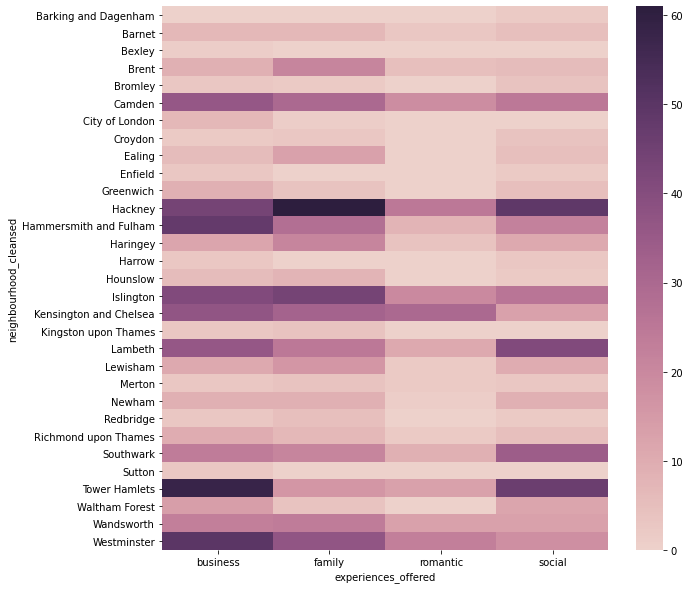

In [38]:
# Импортируем библиотеку для построения графика.
import matplotlib.pyplot as plt

# обозначаем параметры графика.
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dff, cmap=sns.cubehelix_palette(as_cmap=True))

In [ ]:
# Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 
# Необходимые для составления запроса столбцы:

# room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
# price – цена за ночь 
# experiences_offered – вид доступного впечатления (оставить не 'none')

In [41]:
q1 = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr
FROM ldn_listings
WHERE experiences_offered != 'none'
LIMIT 1000
"""
p_night = ph.read_clickhouse(q1, connection=connection_default)
# p_night.value_counts('room_type')
p_night

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
995,Entire home/apt,40.0
996,Entire home/apt,150.0
997,Entire home/apt,250.0
998,Private room,28.0


In [42]:
p_night.value_counts('room_type')

room_type
Entire home/apt    566
Private room       426
Shared room          5
Hotel room           3
dtype: int64

In [44]:
# Далее постройте два графика, используя distplot из библиотеки seaborn:

# На первом отобразите исходные распределения цен для каждого типа жилья
# На втором – логарифмированные значения (np.log())

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


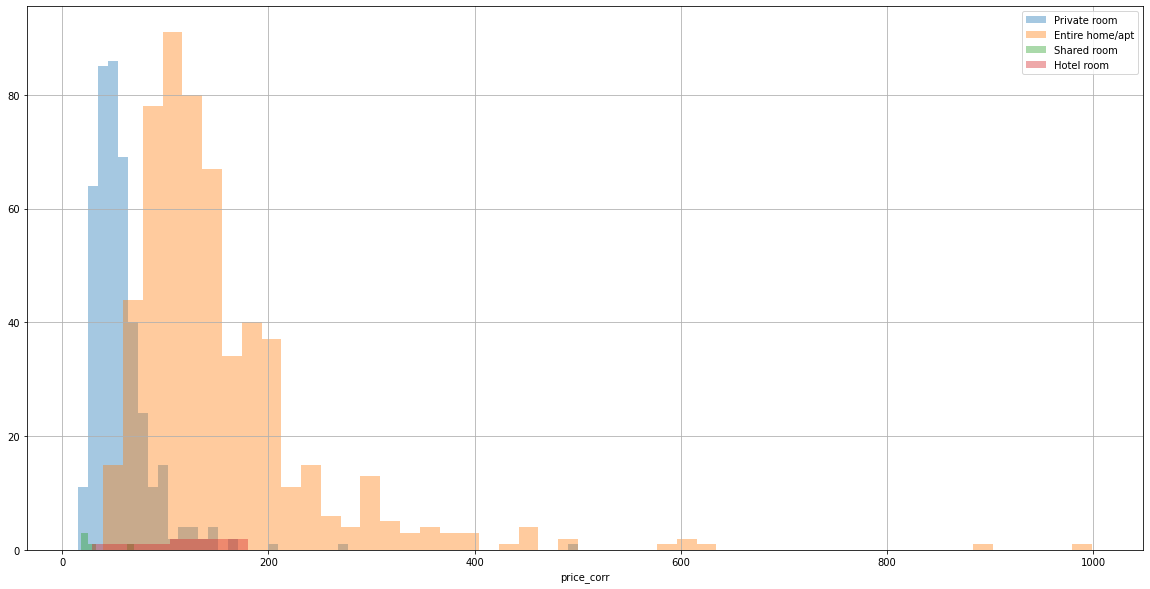

In [43]:
# Строим грфик по каждому из видов комнаты.
plt.rcParams['figure.figsize']=20,10
sns.distplot(p_night.query("room_type =='Private room'").price_corr, kde=False, label='Private room')
sns.distplot(p_night.query("room_type =='Entire home/apt'").price_corr, kde=False, label='Entire home/apt')
sns.distplot(p_night.query("room_type =='Shared room'").price_corr, kde=False, label='Shared room')
sns.distplot(p_night.query("room_type =='Hotel room'").price_corr, kde=False, label='Hotel room')

plt.legend()
plt.grid()

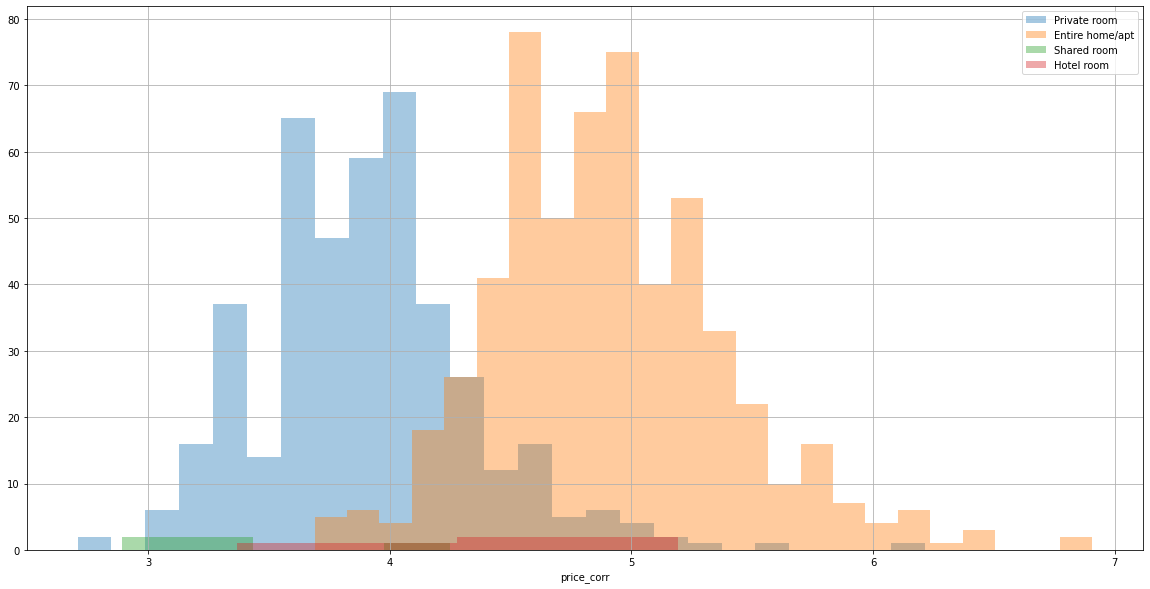

In [46]:
# На втором – логарифмированные значения (np.log())
plt.rcParams['figure.figsize']=20,10
sns.distplot(np.log(p_night.query("room_type =='Private room'").price_corr), kde=False, label='Private room')
sns.distplot(np.log(p_night.query("room_type =='Entire home/apt'").price_corr), kde=False, label='Entire home/apt')
sns.distplot(np.log(p_night.query("room_type =='Shared room'").price_corr), kde=False, label='Shared room')
sns.distplot(np.log(p_night.query("room_type =='Hotel room'").price_corr), kde=False, label='Hotel room')
plt.legend()
plt.grid()

In [47]:
# Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

# room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
# price – цена за ночь
# first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
# Ограничение поставьте на 1000 строк.



In [48]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr,
    first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
first_rev = ph.read_clickhouse(query, connection=connection_default)
first_rev

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [49]:
# Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) 
# в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X).
# Датафрейм должен быть отсортирован по годам.

In [52]:
l_plot = first_rev.groupby(['first_review', 'room_type'], as_index=False) \
         .agg({'price_corr': 'mean'}) \
         .rename(columns={'price_corr': 'avg_price'})
l_plot

,first_review,room_type,avg_price
0,2010-04-14,Private room,29.0
1,2010-07-21,Private room,70.0
2,2010-08-01,Private room,60.0
3,2010-08-18,Private room,65.0
4,2010-08-31,Entire home/apt,80.0
...,...,...,...
778,2019-08-13,Private room,35.0
779,2019-08-18,Private room,23.0
780,2019-09-18,Private room,45.0
781,2020-02-08,Private room,39.0


In [ ]:
# теперь мне нужно сгрупиировать данные по дате (ГОДУ) типу комнаты.

In [83]:
# угадал, посмотри обязательно разбор